# Statistical & Machine Learning Group Project
## Microsoft Malware Prediction
### Swetha Kallam, Tim Hollinger, Rohit Bhalerao

#### Importing the libraries

In [88]:
import numpy as np
import pandas as pd
import os
import random
from pandas   import DataFrame
from numpy import array
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics        import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from sklearn.metrics        import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#### Importing the data

In [2]:
# Setting the working directory where the data is present
#os.chdir('C:\\Users\\skallam\\Documents\\Statistical Learning\\Group Project')

In [3]:
#os.getcwd()

Since the data volume is too big (appr 9M), we take a random sample of 20% of data volume from the train dataset 
And use 60% of it as training data and the remaining as test data

In [4]:
p = 0.1 # 10% of the data
random.seed(5)
kaggle_train = pd.read_csv("train.csv",
                   header = 0,
                   skiprows = lambda i: i>0 and random.random() > p)

train = kaggle_train.sample(frac=0.60) #60% of it as train
test = kaggle_train[~kaggle_train.MachineIdentifier.isin(train.MachineIdentifier)] #rows that are not in train will be put in test

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
print("train: ", train.shape)
print("test: ", test.shape)

train:  (535124, 83)
test:  (356749, 83)


In [6]:
train["HasDetections"].value_counts()
# The training data has almost 50-50 distribution of malware

1    267695
0    267429
Name: HasDetections, dtype: int64

In [7]:
test["HasDetections"].value_counts()
# The test data also has almost 50-50 distribution of malware, so the sampling is fine

0    178516
1    178233
Name: HasDetections, dtype: int64

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 535124 entries, 880866 to 716901
Data columns (total 83 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   MachineIdentifier                                  535124 non-null  object 
 1   ProductName                                        535124 non-null  object 
 2   EngineVersion                                      535124 non-null  object 
 3   AppVersion                                         535124 non-null  object 
 4   AvSigVersion                                       535124 non-null  object 
 5   IsBeta                                             535124 non-null  int64  
 6   RtpStateBitfield                                   533148 non-null  float64
 7   IsSxsPassiveMode                                   535124 non-null  int64  
 8   DefaultBrowsersIdentifier                          25929 non-null   f

We remove the columns if more than 90% of the data is NA

In [9]:
# Finding the columns with null values in more than 90% of the data volume
to_drop = list(train.columns[train.isna().sum() >= 0.9*len(train)].values)
print(to_drop)
# Dropping those columns from both train and test data
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

['DefaultBrowsersIdentifier', 'PuaMode', 'Census_ProcessorClass']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# Separating the features and outcome variable
train_X = train.drop('HasDetections', 1)
train_y = train.HasDetections
test_X = test.drop('HasDetections', 1)
test_y = test.HasDetections

In [11]:
print("train_X: ", train_X.shape)
print("test_X: ", test_X.shape)

train_X:  (535124, 79)
test_X:  (356749, 79)


Categorical variables:

We will drop the columns which have more than 20 categories (we can increase this number later if needed)

In [12]:
# Drop the variables which have more than 20 categories
for col in train_X.columns:
    if train_X[col].dtypes == 'object':
        unique_cat = len(train_X[col].unique())
        print("Variable '{col_name}' has {unique_cat} distinct values".format(col_name=col, unique_cat=unique_cat))
        if unique_cat>20 and col!='MachineIdentifier':
            train_X.drop([col],axis=1,inplace=True)
            test_X.drop([col],axis=1,inplace=True)
            print("Variable", col, "is dropped")

Variable 'MachineIdentifier' has 535124 distinct values
Variable 'ProductName' has 5 distinct values
Variable 'EngineVersion' has 56 distinct values
Variable EngineVersion is dropped
Variable 'AppVersion' has 92 distinct values
Variable AppVersion is dropped
Variable 'AvSigVersion' has 6574 distinct values
Variable AvSigVersion is dropped
Variable 'Platform' has 4 distinct values
Variable 'Processor' has 3 distinct values
Variable 'OsVer' has 18 distinct values
Variable 'OsPlatformSubRelease' has 9 distinct values
Variable 'OsBuildLab' has 470 distinct values
Variable OsBuildLab is dropped
Variable 'SkuEdition' has 8 distinct values
Variable 'SmartScreen' has 12 distinct values
Variable 'Census_MDC2FormFactor' has 12 distinct values
Variable 'Census_DeviceFamily' has 2 distinct values
Variable 'Census_PrimaryDiskTypeName' has 5 distinct values
Variable 'Census_ChassisTypeName' has 33 distinct values
Variable Census_ChassisTypeName is dropped
Variable 'Census_PowerPlatformRoleName' has 

In [13]:
train_X.columns[train_X.dtypes=='object']

Index(['MachineIdentifier', 'ProductName', 'Platform', 'Processor', 'OsVer',
       'OsPlatformSubRelease', 'SkuEdition', 'SmartScreen',
       'Census_MDC2FormFactor', 'Census_DeviceFamily',
       'Census_PrimaryDiskTypeName', 'Census_PowerPlatformRoleName',
       'Census_OSArchitecture', 'Census_OSBranch', 'Census_OSEdition',
       'Census_OSSkuName', 'Census_OSInstallTypeName',
       'Census_OSWUAutoUpdateOptionsName', 'Census_GenuineStateName',
       'Census_ActivationChannel', 'Census_FlightRing'],
      dtype='object')

In [14]:
#ProductName
print(train_X.ProductName.value_counts())
# We will group everything except win8defender as "Others"
print(train_X.ProductName.isna().sum())
# No null values

train_X['ProductName'] = ['win8defender' if x == 'win8defender' else 'Others' for x in train_X['ProductName']]
print(train_X.ProductName.value_counts())

# Do the same for test data
test_X['ProductName'] = ['win8defender' if x == 'win8defender' else 'Others' for x in test_X['ProductName']]

win8defender     529391
mse                5729
mseprerelease         2
scep                  1
fep                   1
Name: ProductName, dtype: int64
0
win8defender    529391
Others            5733
Name: ProductName, dtype: int64


In [15]:
#Platform
print(train_X.Platform.value_counts())
# 861627 is ~96% of total data volume, so here as well
# We will group everything except windows10 as "Others"
print(train_X.Platform.isna().sum())
# No null values

train_X['Platform'] = ['windows10' if x == 'windows10' else 'Others' for x in train_X['Platform']]
print(train_X.Platform.value_counts())

# Do the same for test data
test_X['Platform'] = ['windows10' if x == 'windows10' else 'Others' for x in test_X['Platform']]

windows10      516854
windows8        11770
windows7         5659
windows2016       841
Name: Platform, dtype: int64
0
windows10    516854
Others        18270
Name: Platform, dtype: int64


In [16]:
#Processor
print(train_X.Processor.value_counts())
# Here as well, 30 is only ~3% of the data volume, so we group it with x86 as others
print(train_X.Processor.isna().sum())
# No null values

train_X['Processor'] = ['x64' if x == 'x64' else 'Others' for x in train_X['Processor']]
print(train_X.Processor.value_counts())

# Do the same for test data
test_X['Processor'] = ['x64' if x == 'x64' else 'Others' for x in test_X['Processor']]

x64      486063
x86       49040
arm64        21
Name: Processor, dtype: int64
0
x64       486063
Others     49061
Name: Processor, dtype: int64


In [17]:
#OsPlatformSubRelease
print(train_X.OsPlatformSubRelease.value_counts())
# We keep it as-is, we'll perform dummy encoding later
print(train_X.OsPlatformSubRelease.isna().sum())
# No null values

rs4           234793
rs3           149339
rs2            46950
rs1            43951
th2            25017
th1            16373
windows8.1     11770
windows7        5659
prers5          1272
Name: OsPlatformSubRelease, dtype: int64
0


In [18]:
#SkuEdition
print(train_X.SkuEdition.value_counts())
# We keep Home and Pro as-is, we'll group everything else as Others
print(train_X.SkuEdition.isna().sum())
# No null values

train_X['SkuEdition'] = ['Others' if x not in ['Home','Pro'] 
                                    else x for x in train_X['SkuEdition']]

print(train_X.SkuEdition.value_counts())

test_X['SkuEdition'] = ['Others' if x not in ['Home','Pro'] 
                                    else x for x in test_X['SkuEdition']]

Home               330728
Pro                193438
Invalid              4743
Education            2366
Enterprise           2123
Enterprise LTSB      1173
Cloud                 330
Server                223
Name: SkuEdition, dtype: int64
0
Home      330728
Pro       193438
Others     10958
Name: SkuEdition, dtype: int64


In [19]:
#SmartScreen
print(train_X.SmartScreen.value_counts())
# We keep Home and Pro as-is, we'll group everything else as Others
print(train_X.SmartScreen.isna().sum())
# 317254 null values

# We create new category as "Missing"
train_X['SmartScreen'].fillna(value="Missing", inplace=True)
test_X['SmartScreen'].fillna(value="Missing", inplace=True)

train_X['SmartScreen'] = ['Others' if x not in ['RequireAdmin','ExistsNotSet', 'Missing'] 
                                    else x for x in train_X['SmartScreen']]
print(train_X.SmartScreen.value_counts())

test_X['SmartScreen'] = ['Others' if x not in ['RequireAdmin','ExistsNotSet', 'Missing'] 
                                    else x for x in test_X['SmartScreen']]

RequireAdmin    259748
ExistsNotSet     62172
Off              11311
Warn              8017
Prompt            2105
Block             1295
off                 75
On                  37
&#x02;              27
&#x01;              15
on                   6
Name: SmartScreen, dtype: int64
190316
RequireAdmin    259748
Missing         190316
ExistsNotSet     62172
Others           22888
Name: SmartScreen, dtype: int64


In [20]:
#Census_MDC2FormFactor
print(train_X.Census_MDC2FormFactor.value_counts())
# We will group SmallServer ,MediumServer, LargeServer and IoTOther as Others
print(train_X.Census_MDC2FormFactor.isna().sum())
# no null values

train_X['Census_MDC2FormFactor'] = ['Others' if x not in ['Notebook','Desktop','Convertible','Detachable','AllInOne','PCOther'] 
                                    else x for x in train_X['Census_MDC2FormFactor']]
print(train_X['Census_MDC2FormFactor'].value_counts())

test_X['Census_MDC2FormFactor'] = ['Others' if x not in ['Notebook','Desktop','Convertible','Detachable','AllInOne','PCOther'] 
                                    else x for x in test_X['Census_MDC2FormFactor']]

Notebook        343360
Desktop         116771
Convertible      24187
Detachable       17960
AllInOne         17688
PCOther           8406
LargeTablet       4106
SmallTablet       1905
SmallServer        525
MediumServer       176
LargeServer         39
IoTOther             1
Name: Census_MDC2FormFactor, dtype: int64
0
Notebook       343360
Desktop        116771
Convertible     24187
Detachable      17960
AllInOne        17688
PCOther          8406
Others           6752
Name: Census_MDC2FormFactor, dtype: int64


In [21]:
#Census_DeviceFamily
print(train_X.Census_DeviceFamily.value_counts())
print(train_X.Census_DeviceFamily.isna().sum())
# Looks good

Windows.Desktop    534283
Windows.Server        841
Name: Census_DeviceFamily, dtype: int64
0


In [22]:
#Census_PrimaryDiskTypeName
print(train_X.Census_PrimaryDiskTypeName.value_counts())
print(train_X.Census_PrimaryDiskTypeName.isna().sum())

# num of null values are quite few comparitively, so we replace them with most frequent value "HDD" instead of creating new category
train_X['Census_PrimaryDiskTypeName'].fillna(value="HDD", inplace=True)
test_X['Census_PrimaryDiskTypeName'].fillna(value="HDD", inplace=True)

print(train_X.Census_PrimaryDiskTypeName.value_counts())

HDD            348149
SSD            148123
UNKNOWN         21424
Unspecified     16673
Name: Census_PrimaryDiskTypeName, dtype: int64
755
HDD            348904
SSD            148123
UNKNOWN         21424
Unspecified     16673
Name: Census_PrimaryDiskTypeName, dtype: int64


In [23]:
#Census_PowerPlatformRoleName
print(train_X.Census_PowerPlatformRoleName.value_counts())
print(train_X.Census_PowerPlatformRoleName.isna().sum())


train_X['Census_PowerPlatformRoleName'] = ['Others' if x not in ['Mobile','Desktop','Slate','Workstation'] 
                                    else x for x in train_X['Census_PowerPlatformRoleName']]
print(train_X.Census_PowerPlatformRoleName.value_counts())
test_X['Census_PowerPlatformRoleName'] = ['Others' if x not in ['Mobile','Desktop','Slate','Workstation'] 
                                    else x for x in test_X['Census_PowerPlatformRoleName']]

Mobile               370798
Desktop              123702
Slate                 29700
Workstation            6735
SOHOServer             2290
UNKNOWN                1253
EnterpriseServer        392
AppliancePC             245
PerformanceServer         4
Name: Census_PowerPlatformRoleName, dtype: int64
5
Mobile         370798
Desktop        123702
Slate           29700
Workstation      6735
Others           4189
Name: Census_PowerPlatformRoleName, dtype: int64


In [24]:
#Census_OSArchitecture
print(train_X.Census_OSArchitecture.value_counts())
print(train_X.Census_OSArchitecture.isna().sum())

train_X['Census_OSArchitecture'] = ['amd64' if x == 'amd64' else 'Others' for x in train_X['Census_OSArchitecture']]
print(train_X.Census_OSArchitecture.value_counts())
test_X['Census_OSArchitecture'] = ['amd64' if x == 'amd64' else 'Others' for x in test_X['Census_OSArchitecture']]

amd64    486040
x86       49063
arm64        21
Name: Census_OSArchitecture, dtype: int64
0
amd64     486040
Others     49084
Name: Census_OSArchitecture, dtype: int64


In [25]:
#Census_OSBranch
print(train_X.Census_OSBranch.value_counts())
print(train_X.Census_OSBranch.isna().sum())

train_X['Census_OSBranch'] = ['Others' if x not in ['rs4_release','rs3_release' ,'rs3_release_svc_escrow','rs2_release','rs1_release','th2_release','th2_release_sec','th1_st1'] 
                                    else x for x in train_X['Census_OSBranch']]
print(train_X.Census_OSBranch.value_counts())

test_X['Census_OSBranch'] = ['Others' if x not in ['rs4_release','rs3_release' ,'rs3_release_svc_escrow','rs2_release','rs1_release','th2_release','th2_release_sec','th1_st1'] 
                                    else x for x in test_X['Census_OSBranch']]

rs4_release                  240474
rs3_release                   73927
rs3_release_svc_escrow        71403
rs2_release                   47898
rs1_release                   47333
th2_release                   19844
th2_release_sec               16125
th1_st1                       11753
th1                            4699
rs5_release                     940
rs3_release_svc_escrow_im       377
rs_prerelease                   174
rs_prerelease_flt               169
rs5_release_sigma                 7
rs1_release_sec                   1
Name: Census_OSBranch, dtype: int64
0
rs4_release               240474
rs3_release                73927
rs3_release_svc_escrow     71403
rs2_release                47898
rs1_release                47333
th2_release                19844
th2_release_sec            16125
th1_st1                    11753
Others                      6367
Name: Census_OSBranch, dtype: int64


In [26]:
#Census_OSInstallTypeName
print(train_X.Census_OSInstallTypeName.value_counts())
print(train_X.Census_OSInstallTypeName.isna().sum())
#No issues

UUPUpgrade        156038
IBSClean           98819
Update             95419
Upgrade            75321
Other              50851
Reset              39085
Refresh            12344
Clean               4064
CleanPCRefresh      3183
Name: Census_OSInstallTypeName, dtype: int64
0


In [27]:
#Census_OSWUAutoUpdateOptionsName
print(train_X.Census_OSWUAutoUpdateOptionsName.value_counts())
print(train_X.Census_OSWUAutoUpdateOptionsName.isna().sum())

train_X['Census_OSWUAutoUpdateOptionsName'] = ['Others' if x not in ['FullAuto','UNKNOWN' ,'Notify'] 
                                    else x for x in train_X['Census_OSWUAutoUpdateOptionsName']]

print(train_X.Census_OSWUAutoUpdateOptionsName.value_counts())

test_X['Census_OSWUAutoUpdateOptionsName'] = ['Others' if x not in ['FullAuto','UNKNOWN' ,'Notify'] 
                                    else x for x in test_X['Census_OSWUAutoUpdateOptionsName']]

FullAuto                                 237317
UNKNOWN                                  151115
Notify                                   121972
AutoInstallAndRebootAtMaintenanceTime     22235
Off                                        1644
DownloadNotify                              841
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64
0
FullAuto    237317
UNKNOWN     151115
Notify      121972
Others       24720
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64


In [28]:
#Census_GenuineStateName
print(train_X.Census_GenuineStateName.value_counts())
print(train_X.Census_GenuineStateName.isna().sum())
# No issues

IS_GENUINE         472217
INVALID_LICENSE     48241
OFFLINE             13818
UNKNOWN               848
Name: Census_GenuineStateName, dtype: int64
0


In [29]:
#Census_ActivationChannel
print(train_X.Census_ActivationChannel.value_counts())
print(train_X.Census_ActivationChannel.isna().sum())

train_X['Census_ActivationChannel'] = ['Others' if x not in ['Retail','OEM:DM' ,'Volume:GVLK'] 
                                    else x for x in train_X['Census_ActivationChannel']]
print(train_X.Census_ActivationChannel.value_counts())

test_X['Census_ActivationChannel'] = ['Others' if x not in ['Retail','OEM:DM' ,'Volume:GVLK'] 
                                    else x for x in test_X['Census_ActivationChannel']]

Retail            283562
OEM:DM            204724
Volume:GVLK        27161
OEM:NONSLP         18970
Volume:MAK           484
Retail:TB:Eval       223
Name: Census_ActivationChannel, dtype: int64
0
Retail         283562
OEM:DM         204724
Volume:GVLK     27161
Others          19677
Name: Census_ActivationChannel, dtype: int64


In [30]:
#Census_FlightRing
print(train_X.Census_FlightRing.value_counts())
print(train_X.Census_FlightRing.isna().sum())

train_X['Census_FlightRing'] = ['Others' if x not in ['Retail','NOT_SET' ,'Unknown'] 
                                    else x for x in train_X['Census_FlightRing']]
print(train_X.Census_FlightRing.value_counts())

test_X['Census_FlightRing'] = ['Others' if x not in ['Retail','NOT_SET' ,'Unknown'] 
                                    else x for x in test_X['Census_FlightRing']]

Retail      501064
NOT_SET      17404
Unknown      14612
WIF            645
WIS            622
RP             537
Disabled       239
OSG              1
Name: Census_FlightRing, dtype: int64
0
Retail     501064
NOT_SET     17404
Unknown     14612
Others       2044
Name: Census_FlightRing, dtype: int64


Now we perform dummy encoding on all these variables and drop the original ones

In [31]:
todummy_list = list(train_X.columns[train_X.dtypes=='object'].values)[1:]
todummy_list

['ProductName',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_DeviceFamily',
 'Census_PrimaryDiskTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [32]:
def dummy_df(df, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(df[x], prefix=x, dummy_na=False)
        df = df.drop(x, 1)
        df = pd.concat([df, dummies], axis=1)
    return df

train_X_new = dummy_df(train_X, todummy_list)
test_X_new = dummy_df(test_X, todummy_list)

In [33]:
print("train: ", train_X_new.shape)
print("test: ", test_X_new.shape)

train:  (535124, 185)
test:  (356749, 190)


In [34]:
test_X_new.columns[test_X_new.columns.isin(train_X_new.columns)==False]

Index(['OsVer_10.0.0.96', 'OsVer_10.0.1.144', 'OsVer_10.0.16.0',
       'OsVer_6.3.0.16', 'Census_OSEdition_CloudN',
       'Census_OSEdition_ProfessionalSingleLanguage',
       'Census_OSEdition_ProfessionalWorkstationN',
       'Census_OSEdition_ServerDatacenter', 'Census_OSSkuName_CLOUDN',
       'Census_OSSkuName_DATACENTER_SERVER',
       'Census_OSSkuName_PRO_SINGLE_LANGUAGE',
       'Census_OSSkuName_PRO_WORKSTATION_N'],
      dtype='object')

In [35]:
#test.Census_DeviceFamily.value_counts()

In [36]:
# Looks like the test set had an extra category not present in the training set, to make the code reproducible, 
# we will drop all columns in the test set that are not present in training set
to_drop = list(test_X_new.columns[test_X_new.columns.isin(train_X_new.columns)==False].values)
print(to_drop)
test_X_new.drop(to_drop, axis=1, inplace=True)

to_drop = list(train_X_new.columns[train_X_new.columns.isin(test_X_new.columns)==False].values)
print(to_drop)
train_X_new.drop(to_drop, axis=1, inplace=True)

['OsVer_10.0.0.96', 'OsVer_10.0.1.144', 'OsVer_10.0.16.0', 'OsVer_6.3.0.16', 'Census_OSEdition_CloudN', 'Census_OSEdition_ProfessionalSingleLanguage', 'Census_OSEdition_ProfessionalWorkstationN', 'Census_OSEdition_ServerDatacenter', 'Census_OSSkuName_CLOUDN', 'Census_OSSkuName_DATACENTER_SERVER', 'Census_OSSkuName_PRO_SINGLE_LANGUAGE', 'Census_OSSkuName_PRO_WORKSTATION_N']
['OsVer_10.0.0.1', 'OsVer_10.0.16.36', 'OsVer_10.0.21.0', 'OsVer_10.0.5.0', 'OsVer_10.0.8.0', 'OsVer_6.3.5.0', 'Census_OSSkuName_UNLICENSED']


#### Numeric variables

There are no more missing values in categorical variables since we have already handled them

Now for the remaining columns, although they have numeric data, most of them are actually categorical based on the information provided : example CountryIdentifier, Wdft_IsGamer etc 

So we will replace the NAs with mode/most_frequent value for all the remaining columns

In [37]:
#Checking if there are any more string variables
print(train_X_new.columns[train_X_new.dtypes=='object'])

#Separating the MachineIdentifier column from the features
train_id = train_X_new.MachineIdentifier
test_id = test_X_new.MachineIdentifier

# Now dropping it
train_X_new.drop(['MachineIdentifier'], axis=1, inplace=True)
test_X_new.drop(['MachineIdentifier'], axis=1, inplace=True)

Index(['MachineIdentifier'], dtype='object')


In [38]:
# We will use SimpleImputer from scikit-learn to replace missing values of all numeric columns with most_frequent

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(train_X_new)
train_X_new = pd.DataFrame(data=imp.transform(train_X_new) , columns=train_X_new.columns)

imp.fit(test_X_new)
test_X_new = pd.DataFrame(data=imp.transform(test_X_new) , columns=test_X_new.columns)

In [39]:
test_X_new.head()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_Others,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_FlightRing_NOT_SET,Census_FlightRing_Others,Census_FlightRing_Retail,Census_FlightRing_Unknown
0,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,201.0,15590.0,27.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,7.0,0.0,41571.0,2.0,1.0,1.0,3.0,69164.0,27.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,12.0,142656.0,27.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,53.0,60652.0,27.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,93.0,36825.0,27.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [40]:
train_X_new.head()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,...,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,Census_ActivationChannel_OEM:DM,Census_ActivationChannel_Others,Census_ActivationChannel_Retail,Census_ActivationChannel_Volume:GVLK,Census_FlightRing_NOT_SET,Census_FlightRing_Others,Census_FlightRing_Retail,Census_FlightRing_Unknown
0,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,43.0,12607.0,18.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,60.0,2414.0,27.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,41.0,32973.0,27.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,51.0,40629.0,27.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,7.0,0.0,53447.0,1.0,1.0,1.0,44.0,20554.0,27.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [41]:
# USING LOGISTIC REGRESSION TO FIT EACH FEATURE ONE BY ONE; WE CAN CALCULATE THE AUC ON EACH FEATURE FOR THE TRAINING DATA

# Define the function score that will be used to assess the accuracy of each feature

def score (dataSet: DataFrame, withModel: LogisticRegression, feature: str):
    dataSet[f"p donation {feature}"] = DataFrame(withModel.predict_proba(dataSet[[feature]]))[1]

# Define the function buildLogisticRegression that will be used to instanciate and train a logistic model

def buildLogisticRegression (onDataSet: DataFrame, forVariable: str, target: str) -> LogisticRegression:
    # 1.
    logisticRegressionModel = LogisticRegression(solver = "lbfgs", max_iter = 500)
    # 2.
    logisticRegressionModel.fit(onDataSet[[forVariable]], onDataSet[target])
    # 3. 
    return logisticRegressionModel

# Create two empty lists where the AUC's (for each feature in the feature list) of the training and test sets will be stored

In [42]:
train_X_new['churn'] = train_y.values
test_X_new['churn'] = test_y.values

In [43]:
print(train_X_new.shape)
print(train_y.shape)

print(test_X_new.shape)
print(test_y.shape)

(535124, 178)
(535124,)
(356749, 178)
(356749,)


In [44]:
train_X_new.columns = train_X_new.columns.str.replace(":", "_")
test_X_new.columns = test_X_new.columns.str.replace(":", "_")

### Feature Selection

In [45]:
#features = []
#features = train_X_new.columns.tolist()
#features.remove('churn')
#features.remove('cust_id')
#features1 = features
#features = features[100:]
#target = 'churn'

In [46]:
# CALCULATING THE AUC FOR EACH FEATURE ON TEH LOGISTIC REGRESSION MODEL. WE KEEP THE FEATURES THAT HAVE AUC ABOVE 0.55
#aucsTrain = []
#aucsTest  = []
#for feature in features:
#    mod = buildLogisticRegression(onDataSet = train_X_new, forVariable = feature, target = target)
#    score(dataSet =  train_X_new, withModel = mod, feature = feature)
#    score(dataSet =  train_X_new, withModel = mod, feature = feature)
    
#    aucsTrain.append(roc_auc_score(array(train_X_new[target]),array(train_X_new[f"p donation {feature}"])))
#    aucsTest.append(roc_auc_score(array(train_X_new[target]),array(train_X_new[f"p donation {feature}"])))

#aucs = {"features":features,"training":aucsTrain,"test":aucsTest}


#df_aucs = DataFrame(aucs).sort_values(by=["test"], ascending = False)
#df_aucs['to_keep'] = 1
#df_aucs.loc[df_aucs['test'] <= 0.5, 'to_keep'] = 0

#df_aucs

In [47]:
#features = list(df_aucs.loc[df_aucs['to_keep'] == 1, 'features'].values)


In [48]:
#features

'AVProductsInstalled',
 'Census_TotalPhysicalRAM',
 'AVProductStatesIdentifier',
 'Census_ProcessorCoreCount',
 'Census_PrimaryDiskTotalCapacity',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_ProcessorModelIdentifier',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Wdft_IsGamer',
 'Census_OSBuildNumber',
 'OsBuild',
 'IeVerIdentifier',
 'Census_OSBuildRevision',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsTouchEnabled',
 'Census_SystemVolumeTotalCapacity',
 'IsProtected',
 'OsSuite',
 'Census_FirmwareManufacturerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'RtpStateBitfield',
 'LocaleEnglishNameIdentifier',
 'AVProductsEnabled',
 'Census_HasOpticalDiskDrive',
 'IsSxsPassiveMode',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSUILocaleIdentifier',
 'Census_IsVirtualDevice',
 'Census_OSInstallLanguageIdentifier',
 'CountryIdentifier',
 'GeoNameIdentifier',
 'Census_IsPenCapable',
 'Census_ProcessorManufacturerIdentifier',
 'CityIdentifier',
 'Census_OEMModelIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_IsSecureBootEnabled',
 'HasTpm',
 'Firewall',
 'SMode',
 'Census_IsPortableOperatingSystem',
 'Census_IsFlightsDisabled',
 'AutoSampleOptIn',
 'Census_ThresholdOptIn'
 'SmartScreen_ExistsNotSet',
 'SmartScreen_RequireAdmin',
 'Processor_Others',
 'Processor_x64',
 'Census_OSArchitecture_amd64',
 'Census_OSArchitecture_Others',
 'Census_OSBranch_rs4_release',
 'OsPlatformSubRelease_rs4',
 'Census_PowerPlatformRoleName_Slate',
 'Wdft_RegionIdentifier',
 'SmartScreen_Missing',
 'Census_PowerPlatformRoleName_Desktop',
 'Census_MDC2FormFactor_Desktop',
 'SkuEdition_Pro',
 'Census_OSBranch_rs3_release',
 'SkuEdition_Home',
 'Census_PrimaryDiskTypeName_HDD',
 'Census_MDC2FormFactor_Detachable',
 'Census_OSBranch_rs1_release',
 'OsPlatformSubRelease_rs1',
 'Census_MDC2FormFactor_Others',
 'OsPlatformSubRelease_rs3',
 'Census_OSBranch_rs3_release_svc_escrow',
 'Census_PrimaryDiskTypeName_UNKNOWN',
 'Census_OSBranch_rs2_release',
 'OsPlatformSubRelease_rs2',
 'Census_MDC2FormFactor_Notebook',
 'Census_PowerPlatformRoleName_Mobile',
 'Census_PrimaryDiskTypeName_Unspecified',
 'OsPlatformSubRelease_th2',
 'SmartScreen_Others',
 'Census_PrimaryDiskTypeName_SSD',
 'Census_OSBranch_Others',
 'Census_MDC2FormFactor_AllInOne',
 'OsPlatformSubRelease_th1',
 'Census_PowerPlatformRoleName_Others',
 'OsPlatformSubRelease_windows8.1',
 'Census_DeviceFamily_Windows.Desktop',
 'Census_DeviceFamily_Windows.Server',
 'Census_PowerPlatformRoleName_Workstation',
 'OsPlatformSubRelease_prers5',
 'Census_MDC2FormFactor_PCOther',
 'Census_OSBranch_th1_st1',
 'Census_MDC2FormFactor_Convertible',
 'SkuEdition_Others',
 'ProductName_Others',
 'ProductName_win8defender',
 'OsPlatformSubRelease_windows7',
 'Platform_windows10',
 'Platform_Others'
 'Census_OSInstallTypeName_UUPUpgrade',
 'Census_OSWUAutoUpdateOptionsName_FullAuto',
 'Census_OSWUAutoUpdateOptionsName_Notify',
 'Census_ActivationChannel_Volume:GVLK',
 'Census_OSInstallTypeName_IBSClean',
 'Census_ActivationChannel_Retail',
 'Census_OSInstallTypeName_Update',
 'Census_OSInstallTypeName_Upgrade',
 'Census_OSInstallTypeName_Other',
 'Census_OSInstallTypeName_Reset',
 'Census_OSBranch_th2_release_sec',
 'Census_ActivationChannel_OEM:DM',
 'Census_GenuineStateName_OFFLINE',
 'Census_FlightRing_Retail',
 'Census_OSWUAutoUpdateOptionsName_UNKNOWN',
 'Census_OSInstallTypeName_Refresh',
 'Census_FlightRing_Unknown',
 'Census_OSWUAutoUpdateOptionsName_Others',
 'Census_GenuineStateName_INVALID_LICENSE',
 'Census_ActivationChannel_Others',
 'Census_GenuineStateName_UNKNOWN',
 'Census_OSInstallTypeName_CleanPCRefresh',
 'Census_FlightRing_Others',
 'Census_OSBranch_th2_release',
 'Census_FlightRing_NOT_SET',
 'Census_OSInstallTypeName_Clean',
 'Census_GenuineStateName_IS_GENUINE'

In [49]:
features = ['AVProductsInstalled', 'Census_TotalPhysicalRAM', 'AVProductStatesIdentifier', 
            'Census_ProcessorCoreCount', 'Census_PrimaryDiskTotalCapacity', 
            'Census_InternalPrimaryDiagonalDisplaySizeInInches', 'Census_ProcessorModelIdentifier', 
            'Census_InternalPrimaryDisplayResolutionHorizontal', 'Wdft_IsGamer', 'Census_OSBuildNumber', 
            'OsBuild', 'IeVerIdentifier', 'Census_OSBuildRevision', 'Census_IsAlwaysOnAlwaysConnectedCapable', 
            'Census_IsTouchEnabled', 'Census_SystemVolumeTotalCapacity', 'IsProtected', 'OsSuite', 
            'Census_FirmwareManufacturerIdentifier', 'Census_OEMNameIdentifier', 
            'Census_InternalPrimaryDisplayResolutionVertical', 'RtpStateBitfield', 'LocaleEnglishNameIdentifier', 
            'AVProductsEnabled', 'Census_HasOpticalDiskDrive', 'IsSxsPassiveMode', 
            'Census_InternalBatteryNumberOfCharges', 'Census_OSUILocaleIdentifier', 'Census_IsVirtualDevice', 
            'Census_OSInstallLanguageIdentifier', 'CountryIdentifier', 'GeoNameIdentifier', 'Census_IsPenCapable', 
            'Census_ProcessorManufacturerIdentifier', 'CityIdentifier', 'Census_OEMModelIdentifier', 
            'Census_FirmwareVersionIdentifier', 'Census_IsSecureBootEnabled', 'HasTpm', 'Firewall', 'SMode', 
            'Census_IsPortableOperatingSystem', 'Census_IsFlightsDisabled', 'AutoSampleOptIn', 
            'Census_ThresholdOptIn' 'SmartScreen_ExistsNotSet', 'SmartScreen_RequireAdmin', 'Processor_Others', 
            'Processor_x64', 'Census_OSArchitecture_amd64', 'Census_OSArchitecture_Others', 
            'Census_OSBranch_rs4_release', 'OsPlatformSubRelease_rs4', 'Census_PowerPlatformRoleName_Slate', 
            'Wdft_RegionIdentifier', 'SmartScreen_Missing', 'Census_PowerPlatformRoleName_Desktop', 
            'Census_MDC2FormFactor_Desktop', 'SkuEdition_Pro', 'Census_OSBranch_rs3_release', 'SkuEdition_Home', 
            'Census_PrimaryDiskTypeName_HDD', 'Census_MDC2FormFactor_Detachable', 'Census_OSBranch_rs1_release', 
            'OsPlatformSubRelease_rs1', 'Census_MDC2FormFactor_Others', 'OsPlatformSubRelease_rs3', 
            'Census_OSBranch_rs3_release_svc_escrow', 'Census_PrimaryDiskTypeName_UNKNOWN', 
            'Census_OSBranch_rs2_release', 'OsPlatformSubRelease_rs2', 'Census_MDC2FormFactor_Notebook', 
            'Census_PowerPlatformRoleName_Mobile', 'Census_PrimaryDiskTypeName_Unspecified', 
            'OsPlatformSubRelease_th2', 'SmartScreen_Others', 'Census_PrimaryDiskTypeName_SSD', 
            'Census_OSBranch_Others', 'Census_MDC2FormFactor_AllInOne', 'OsPlatformSubRelease_th1', 
            'Census_PowerPlatformRoleName_Others', 'OsPlatformSubRelease_windows8.1', 
            'Census_DeviceFamily_Windows.Desktop', 'Census_DeviceFamily_Windows.Server', 
            'Census_PowerPlatformRoleName_Workstation', 'OsPlatformSubRelease_prers5', 
            'Census_MDC2FormFactor_PCOther', 'Census_OSBranch_th1_st1', 'Census_MDC2FormFactor_Convertible', 
            'SkuEdition_Others', 'ProductName_Others', 'ProductName_win8defender', 'OsPlatformSubRelease_windows7', 
            'Platform_windows10', 'Platform_Others' 'Census_OSInstallTypeName_UUPUpgrade', 
            'Census_OSWUAutoUpdateOptionsName_FullAuto', 'Census_OSWUAutoUpdateOptionsName_Notify', 
            'Census_ActivationChannel_Volume_GVLK', 'Census_OSInstallTypeName_IBSClean', 
            'Census_ActivationChannel_Retail', 'Census_OSInstallTypeName_Update', 
            'Census_OSInstallTypeName_Upgrade', 'Census_OSInstallTypeName_Other', 'Census_OSInstallTypeName_Reset', 
            'Census_OSBranch_th2_release_sec', 'Census_ActivationChannel_OEM_DM', 
            'Census_GenuineStateName_OFFLINE', 'Census_FlightRing_Retail', 
            'Census_OSWUAutoUpdateOptionsName_UNKNOWN', 'Census_OSInstallTypeName_Refresh', 
            'Census_FlightRing_Unknown', 'Census_OSWUAutoUpdateOptionsName_Others', 
            'Census_GenuineStateName_INVALID_LICENSE', 'Census_ActivationChannel_Others', 
            'Census_GenuineStateName_UNKNOWN', 'Census_OSInstallTypeName_CleanPCRefresh', 
            'Census_FlightRing_Others', 'Census_OSBranch_th2_release', 'Census_FlightRing_NOT_SET', 
            'Census_OSInstallTypeName_Clean', 'Census_GenuineStateName_IS_GENUINE']

In [50]:
features.remove('Platform_OthersCensus_OSInstallTypeName_UUPUpgrade')
features.remove('Census_ThresholdOptInSmartScreen_ExistsNotSet')

In [51]:
y = train_y

In [52]:
x = train_X_new[features]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=.3, random_state = 123)

In [54]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100)
boostedTree  = GradientBoostingClassifier()
svm          = SVC(gamma = "scale", probability = True)

In [55]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "boostedTree"  :boostedTree,
          "randomForest" :randomForest
         }

In [56]:
for model in models:
    models[model].fit(X_train,y_train)
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
boostedTree has been trained successfully
randomForest has been trained successfully


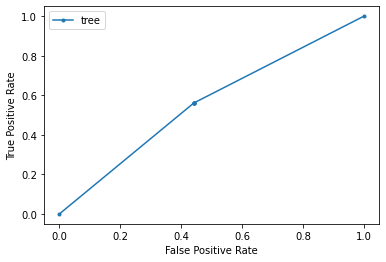

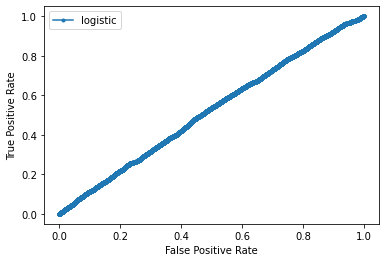

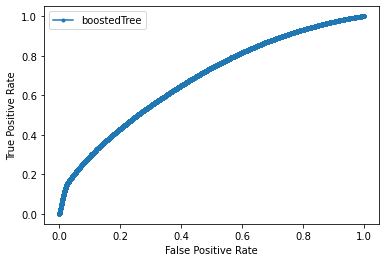

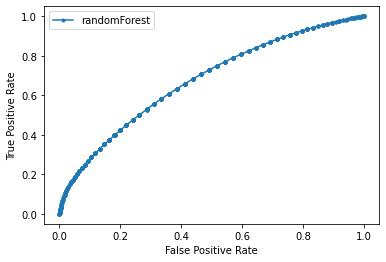

In [57]:
performances_train = {}


for model in models:
    predictions   = models[model].predict(X_test)
    probabilities = DataFrame(models[model].predict_proba(X_test))[1]
    accuracy      = accuracy_score(y_test,predictions)
    auc           = roc_auc_score(array(y_test),array(probabilities))
#    precision     = precision_recall_fscore_support(array(y_train), array(probabilities), average='macro')
    performances_train[model] = {"Accuracy":accuracy,"AUC":auc}
    fpr, tpr, _ = roc_curve(y_test, array(probabilities))
    plt.plot(fpr, tpr, marker='.', label=model)
# axis labelsµ
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
# show the legend
    plt.legend()
# show the plot
    plt.show()

In [58]:
DataFrame(performances_train)

,tree,logistic,boostedTree,randomForest
Accuracy,0.559699,0.500118,0.624656,0.623634
AUC,0.559738,0.521787,0.681540,0.675665


In [59]:
# neighbours? which one do we select since we're removing neighbours
#model = boostedTree
#model.fit(train_X_new ,train_y)

In [60]:
#model = GradientBoostingClassifier(n_estimators = 400, max_depth = 3, learning_rate = 0.01, subsample = 0.618)
#model.fit(X_train, y_train)

In [61]:
#performances_train = {}

#predictions   = model.predict(X_train)
#probabilities = DataFrame(model.predict_proba(X_train))[1]
#accuracy      = accuracy_score(y_train,predictions)
#auc           = roc_auc_score(array(y_train),array(probabilities))
    
#performances_train[model] = {"Accuracy":accuracy,"AUC":auc}

In [62]:
#model

In [63]:
#DataFrame(performances_train)

### Hyperparameter Tuning

In [64]:
#model = GradientBoostingClassifier(random_state = 1)
#params = {"n_estimators" : [200,300,400,450],
#          "max_depth" : [1,2,3,5,6],
#          "learning_rate" : [0.1, 0.05, 0.01],
#          "subsample" : [0.5, 0.6, 0.8, 0.9, 0.95],
#          "min_samples_split" : [1,2,3,4],
#          "min_samples_leaf" : [1,2,3]}

#gs = GridSearchCV(model, params, cv = 5, scoring = 'roc_auc')

#gs.fit(X_train, y_train)

#print("Best AUC ROC : ", gs.best_score_)
#print("Best parameters : ", gs.best_params_)

In [65]:
model_grid = {}

In [66]:
#cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
#model = LGBMClassifier(boosting_type='gbdt', random_state=1)
#parameters = {
#    'objective': ['binary'],
#    'learning_rate': [0.01, 0.05, 0.1, 0.2],
#    'num_leaves': [6, 8, 12, 16],
#    'max_depth': [3, 5, 8],
#    'subsample': [0.7, 0.75],
#    'colsample_bytree': [0.65, 0.66],
#    'n_estimators': [100],
#    'reg_alpha': [1, 1.2],
#    'reg_lambda': [1, 1.2, 1.4],
#}

#clf = GridSearchCV(model, parameters, scoring='roc_auc', n_jobs=1, cv=cv, verbose=10, return_train_score=True)
#clf.fit(X_train, np.ravel(y_train))
#model_grid['gb_lasso'] = clf  # Store the CV result
#best_test_idx = np.where(clf.cv_results_['rank_test_score'] == 1)[0][0]
#print('Best model - AUC train:', clf.cv_results_['mean_train_score'][best_test_idx])
#print('Best model - AUC test:', clf.cv_results_['mean_test_score'][best_test_idx])
#print("Best model - params:", clf.best_params_)


In [67]:
#features

In [68]:
#Best model - AUC train: 0.7108138100032287
#Best model - AUC test: 0.6941913793049327
#Best model - params: {'colsample_bytree': 0.66, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 1.2, 'reg_lambda': 1, 'subsample': 0.7}

In [69]:
#model = GradientBoostingClassifier(random_state = 1, 'colsample_bytree': 0.66, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 16, 'objective': 'binary', 'reg_alpha': 1.2, 'reg_lambda': 1, 'subsample': 0.7)


In [70]:
model = LGBMClassifier(boosting_type = 'gbdt', random_state=1, colsample_bytree = 0.66, learning_rate = 0.2, 
                       max_depth = 5, n_estimators = 100, num_leaves = 16, objective = 'binary', 
                       reg_alpha = 1.2, reg_lambda = 1, subsample = 0.7)


In [71]:
model.fit(X_train,y_train)
print(f"{model} has been trained successfully")

LGBMClassifier(colsample_bytree=0.66, learning_rate=0.2, max_depth=5,
               num_leaves=16, objective='binary', random_state=1, reg_alpha=1.2,
               reg_lambda=1, subsample=0.7) has been trained successfully


In [72]:
performances_train = {}



predictions   = model.predict(X_test)
probabilities = DataFrame(model.predict_proba(X_test))[1]
accuracy      = accuracy_score(y_test,predictions)
auc           = roc_auc_score(array(y_test),array(probabilities))
    
performances_train[model] = {"Accuracy":accuracy,"AUC":auc}

In [73]:
DataFrame(performances_train)

,"LGBMClassifier(colsample_bytree=0.66, learning_rate=0.2, max_depth=5,\n num_leaves=16, objective='binary', random_state=1, reg_alpha=1.2,\n reg_lambda=1, subsample=0.7)"
AUC,0.694631
Accuracy,0.635712


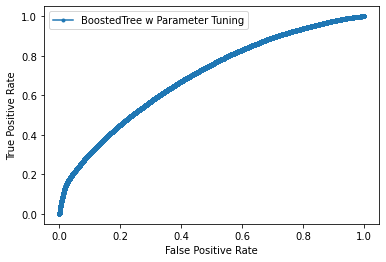

In [76]:
fpr, tpr, _ = roc_curve(y_test, array(probabilities))
plt.plot(fpr, tpr, marker='.', label="BoostedTree w Parameter Tuning")
# axis labelsµ
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

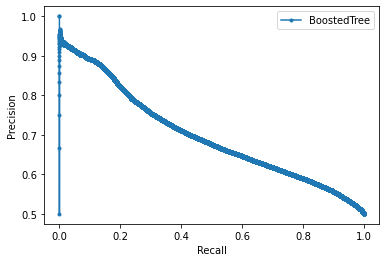

In [80]:
precision, recall, _ = precision_recall_curve(y_test, array(probabilities))
plt.plot(recall, precision, marker='.', label='BoostedTree')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [89]:
precision = precision_score(y_test, predictions, average='binary')
print('Precision: %.3f' % precision)

recall = recall_score(y_test, predictions, average='binary')
print('Recall: %.3f' % recall)

score = f1_score(y_test, predictions, average='binary')
print('F-Measure: %.3f' % score)

Precision: 0.638
Recall: 0.628
F-Measure: 0.633
